In [1]:
!pip install pytorch-lightning datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00


In [3]:
from pprint import pprint
import functools

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pytorch_lightning as pl

from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

from datasets.arrow_dataset import Dataset
import pyarrow as pa

In [4]:
# Define the maximum number of samples to be considered
MAX_SAMPLES = 5000

# Read a CSV file ('combined_data.csv') into a Pandas DataFrame (df)
df = pd.read_csv('combined_data.csv')

# Extract spam (label = 1) and ham (label = 0) messages from the DataFrame
spams = df.text[df.label == 1].to_numpy()
hams = df.text[df.label == 0].to_numpy()

# Display the initial number of spam and ham messages
print(f'Initial number of spams: {len(spams)}\nInitial number of hams : {len(hams)}')

# Limit the number of samples to MAX_SAMPLES for both spam and ham messages
spams = spams[:MAX_SAMPLES]
hams = hams[:MAX_SAMPLES]

# Ensure that the number of spam and ham samples are equal
assert len(spams) == len(hams)

# Print a message indicating that the data is balanced and limited to MAX_SAMPLES
print('Data is balanced and limited to MAX_SAMPLES')

# Display the final number of spam and ham messages after limiting the samples
print(f'Final number of fake news : {len(spams)}\nFinal number of true news : {len(hams)}')


Initial number of spams: 43910
Initial number of hams : 39538
Data is balanced and limited to MAX_SAMPLES
Final number of fake news : 5000
Final number of true news : 5000


In [5]:
# Function to split an array into training, validation, and test sets
def get_train_val_test(arr, train_split=0.75, val_test_split=0.5):
    train, val_test = train_test_split(arr, train_size=train_split, shuffle=True)
    val, test = train_test_split(val_test, train_size=val_test_split, shuffle=True)
    return train, val, test

# Function to concatenate, shuffle, and create labels for two arrays
def concat_shuffle_and_create_labels(arr1, arr2):
    # Concatenate two arrays (arr1 and arr2)
    arr = np.concatenate((arr1, arr2))

    # Create labels (1 for spams, 0 for hams) and shuffle the data
    labels = np.concatenate((np.ones(len(arr1)), np.zeros(len(arr2))))
    permutation = np.random.permutation(len(arr))

    # Return the shuffled array and corresponding labels
    return arr[permutation], labels[permutation]

In [6]:
# Split spams and hams into training, validation, and test sets
train_spams, val_spams, test_spams = get_train_val_test(spams)
train_hams, val_hams, test_hams = get_train_val_test(hams)

# Concatenate, shuffle, and create labels for training, validation and test data
train_mails, train_labels = concat_shuffle_and_create_labels(train_spams, train_hams)
val_mails, val_labels = concat_shuffle_and_create_labels(val_spams, val_hams)
test_mails, test_labels = concat_shuffle_and_create_labels(test_spams, test_hams)

In [7]:
# Specify the BERT model name to be used
model_name = 'bert-base-cased'

# Create a tokenizer instance for the specified BERT model
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [8]:
# Define the schema for the Arrow dataset
schema = pa.schema([
    pa.field('mails', pa.string()),
    pa.field('labels', pa.int64())
])

# Function to create an Arrow dataset from mails and labels
def create_arrow_dataset(mails, labels):
    return Dataset(pa.Table.from_arrays((mails, labels), schema=schema))

# Create Arrow datasets for training, validation, and test sets
train_dataset = create_arrow_dataset(train_mails, train_labels)
val_dataset = create_arrow_dataset(val_mails, val_labels)
test_dataset = create_arrow_dataset(test_mails, test_labels)

In [9]:
# Function to tokenize a batch of samples using a tokenizer
def tokenize_batch(samples, tokenizer):
    # Extract mails and labels from samples
    text = [sample["mails"] for sample in samples]
    labels = torch.tensor([sample["labels"] for sample in samples])

    # Tokenize the text using the specified tokenizer
    tokens = tokenizer(text, padding="max_length", truncation=True, return_tensors="pt")

    # Return a dictionary containing tokenized input, attention mask, labels, and original sentences
    return {"input_ids": tokens.input_ids, "attention_mask": tokens.attention_mask, "labels": labels, "sentences": text}

In [10]:
# Create a DataLoader for training, validation and test with tokenization applied
train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer)
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=16,
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer)
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=8,
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer)
)

In [11]:
# Define a Lightning model for sequence classification
class LightningModel(pl.LightningModule):
    def __init__(self, model_name, num_labels, lr, weight_decay, from_scratch=False):
        super().__init__()
        # Save hyperparameters
        self.save_hyperparameters()

        # Initialize the model based on whether it is loaded from scratch or pretrained
        if from_scratch:
            config = AutoConfig.from_pretrained(model_name, num_labels=num_labels)
            self.model = AutoModelForSequenceClassification.from_config(config)
        else:
            self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

        # Assign other hyperparameters
        self.lr = lr
        self.weight_decay = weight_decay
        self.num_labels = self.model.num_labels
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask):
        return self.model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

    def training_step(self, input_ids, attention_mask, labels):
        # Forward pass
        out = self.forward(input_ids=input_ids, attention_mask=attention_mask)

        # Compute the training loss and accuracy
        logits = out.logits
        loss = self.loss_fn(logits.view(-1, self.num_labels), labels.view(-1))
        preds = torch.max(logits, -1).indices
        acc = (labels == preds).float().mean()

        return loss, acc

    def validation_step(self, input_ids, attention_mask, labels, batch_index):
        # Forward pass during validation
        out = self.forward(input_ids=input_ids, attention_mask=attention_mask)
        logits = out.logits

        # Compute the validation loss and accuracy
        loss = self.loss_fn(logits.view(-1, self.num_labels), labels.view(-1))
        preds = torch.max(logits, -1).indices
        acc = (labels == preds).float().mean()

        return loss, acc

    def predict_step(self, input_ids, attention_mask, batch_idx):
        # Forward pass during prediction
        out = self.forward(input_ids, attention_mask)

        # Return the predicted labels
        return torch.max(out.logits, -1).indices

    def configure_optimizers(self):
        # Configure AdamW optimizer with specified learning rate and weight decay
        return torch.optim.AdamW(
            self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay
        )

In [12]:
num_labels = 2
lightning_model = LightningModel('bert-base-cased', num_labels, lr=3e-5, weight_decay=0.)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Function to train one epoch of the model
def train_epoch(model, device, dataloader, optimizer):
    train_losses, train_accs = [], []
    model.train()

    for batch in dataloader:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)

        # Zero the gradients, perform forward and backward passes, and update weights
        optimizer.zero_grad()
        loss, acc = model.training_step(input_ids, attention_mask, labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_accs.append(acc.item())

    return train_losses, train_accs

# Function to evaluate the model on the validation set
def val_epoch(model, device, dataloader):
    val_losses, val_accs = [], []
    model.eval()

    with torch.no_grad():
        for index, batch in enumerate(dataloader):
            input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)

            # Perform forward pass without updating weights
            loss, acc = model.validation_step(input_ids, attention_mask, labels, index)

            val_losses.append(loss.item())
            val_accs.append(acc.item())

    return val_losses, val_accs

In [14]:
# Function to train the model for a specified number of epochs
def train(model, num_epochs, train_dataloader, val_dataloader, device):
    optimizer = model.configure_optimizers()
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    # Move the model to the specified device
    model = model.to(device)

    for epoch in range(num_epochs):
        # Perform one training epoch
        train_losses, train_accs = train_epoch(model, device, train_dataloader, optimizer)

        # Evaluate the model on the validation set
        val_losses, val_accs = val_epoch(model, device, val_dataloader)

        # Calculate average training and validation loss
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        # Calculate average training and validation accuracy
        train_acc = np.mean(train_accs) * 100
        val_acc = np.mean(val_accs) * 100

        # Print and store the results for each epoch
        print("Epoch:{}/{} AVG Training Loss: {:.3f} AVG Test Loss: {:.3f} AVG Training Acc: {:.2f} % AVG Test Acc: {:.2f} %".format(
            epoch + 1, num_epochs, train_loss, val_loss, train_acc, val_acc))

        # Append results to the history dictionary
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    return history

In [15]:
# Set the device based on GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 1

# Train the Lightning model for the specified number of epochs
train(lightning_model, num_epochs, train_dataloader, val_dataloader, device)

Device : cuda:0
Epoch:1/1 AVG Training Loss: 0.201 AVG Test Loss: 0.084 AVG Training Acc: 90.72 % AVG Test Acc: 96.99 %


{'train_loss': [0.20070558955653636],
 'val_loss': [0.08431383068791201],
 'train_acc': [90.72050462399464],
 'val_acc': [96.99367088607595]}

In [18]:
# Clear CUDA memory cache
torch.cuda.empty_cache()

# Function to evaluate the model on a dataloader
def evaluate(model, dataloader, device):
    accs = []
    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)

            # Forward pass during evaluation
            out = model.forward(input_ids, attention_mask)
            batch_preds = torch.max(out.logits, -1).indices

            # Calculate accuracy for the batch
            accs.append((batch_preds == labels).float().mean().item())

    # Return the average accuracy over all batches
    return np.mean(accs)


In [19]:
# Evaluate the model with the test dataloader
evaluate(lightning_model, test_dataloader, device)

0.9777070063694268

In [25]:
# Mapping from label index to label name
ID_TO_LABEL = {
    0: 'hams',
    1: 'spams'
}

# Function to make predictions using the model
def make_prediction(model, tokenizer, sentence, device):
    model.eval()
    # Tokenize the input sentence
    tokenized_sentence = tokenizer(sentence, return_tensors="pt")
    input_ids, attention_mask = tokenized_sentence.input_ids.to(device), tokenized_sentence.attention_mask.to(device)

    # Forward pass through the model
    out = model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )

    # Get logits and probabilities
    logits = out.logits
    probas = torch.softmax(logits, -1).squeeze()

    # Get the predicted label and its probability
    pred = torch.argmax(probas)
    predicted_label = ID_TO_LABEL[pred.item()]
    probability = probas[pred].item()

    return predicted_label, probability

In [29]:
# Example spam
spam_mail = "SPECIAL OFFER ! GET 50% of reduction !"

pred, proba = make_prediction(lightning_model, tokenizer, spam_mail, device)

print('Categorized as {} with {:.1f}%'.format(
    pred,
    proba * 100
))

Categorized as spams with 90.0%


In [30]:
# Example ham
ham_mail = "Hi Marc,I hope this message finds you well! Just a quick reminder that the baby shower is scheduled for this Monday. We're all looking forward to celebrating this joyous occasion with you and your growing family."

pred, proba = make_prediction(lightning_model, tokenizer, ham_mail, device)

print('Categorized as {} with {:.1f}%'.format(
    pred,
    proba * 100
))

Categorized as hams with 99.1%


In [35]:
# Get the true labels from the test dataset
labels = test_dataset['labels']

# Set the model to evaluation mode
lightning_model.eval()

# List to store predictions
preds = []

# Iterate over batches in the test dataloader
for i, batch in enumerate(test_dataloader):
    input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)

    # Get predictions for the batch
    batch_pred = lightning_model.predict_step(input_ids, attention_mask, i)
    preds.extend(batch_pred)

# Convert predictions to CPU
cpu_preds = [pred.item() for pred in preds]

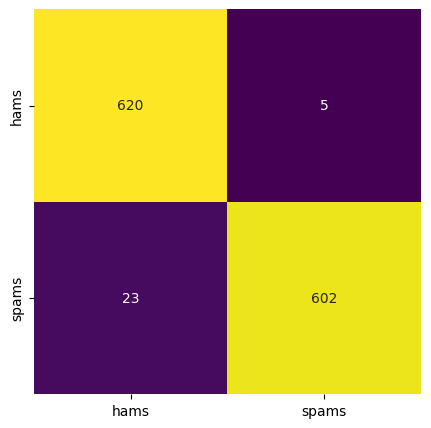

In [50]:
# List of label names
label_names = list(ID_TO_LABEL.values())

# Function to plot confusion matrix
def plot_confusion_matrix(labels, preds, label_names):
    # Compute confusion matrix and normalize it
    confusion_norm = confusion_matrix(labels, preds, labels=list(range(len(label_names))), normalize="true")
    confusion = confusion_matrix(labels, preds, labels=list(range(len(label_names))))

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(5, 5))
    sns.heatmap(
        confusion_norm,
        annot=confusion,
        cbar=False,
        fmt="d",
        xticklabels=label_names,
        yticklabels=label_names,
        cmap="viridis"
    )

# Plot the confusion matrix
plot_confusion_matrix(labels, cpu_preds, label_names)